### Boilinger Bands using backtrader python library non nueral network approach

In [ ]:
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import pandas as pd
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# for pandas_datareader, otherwise it might have issues, sometimes there is some version mismatch
pd.core.common.is_list_like = pd.api.types.is_list_like

# make pandas to print dataframes nicely
pd.set_option('expand_frame_repr', False)  

In [ ]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.insert(0,'/content/drive/My Drive/SwingTrader')

In [ ]:
!pip install git+https://github.com/quantopian/pyfolio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-38p026gf
  Running command git clone --filter=blob:none --quiet https://github.com/quantopian/pyfolio /tmp/pip-req-build-38p026gf
  Resolved https://github.com/quantopian/pyfolio to commit 4b901f6d73aa02ceb6d04b7d83502e5c6f2e81aa
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.5 MB/s eta 0:00:00
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-py3-none-any.whl size=75761 sha256=cb054688e874a5f623b899332033e16e77b997c8f0dca84cacdf16205d1d2734
  Stored in directory: /tmp/pip-ephem-wheel-cache-7zilsnaq/wheels/25/2f/dd/558b6be9405213c9f6fdb1c5a062028a4da70862268f4116e6
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.w

In [ ]:
#!pip install pyfolio

In [ ]:
!pip install backtrader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 8.2 MB/s eta 0:00:00


### Download data and prepare

In [ ]:
#!pip install yfinance

In [ ]:
from dataloaders import get_data_from_yahoo

In [ ]:
ticker = "MSFT"

In [ ]:
start_date = "2013-01-01"
end_date = "2023-03-31"

In [ ]:
stock = get_data_from_yahoo.get_data(ticker, start_date, end_date)

[*********************100%***********************]  1 of 1 completed
connected to yahoo


In [ ]:
import yfinance as yf
df = pd.DataFrame()
AAPL  = yf.download("AAPL" , start="2013-01-01", end="2023-03-31",group_by="ticker") # Apple
AMZN  = yf.download("AMZN" , start="2013-01-01", end="2023-03-31",group_by="ticker") # Amazon
GOOG  = yf.download("GOOG", start="2013-01-01", end="2023-03-31",group_by="ticker") # Google (Alphabet)
MSFT  = yf.download("MSFT" , start="2013-01-01", end="2023-03-31",group_by="ticker") # Microsoft



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


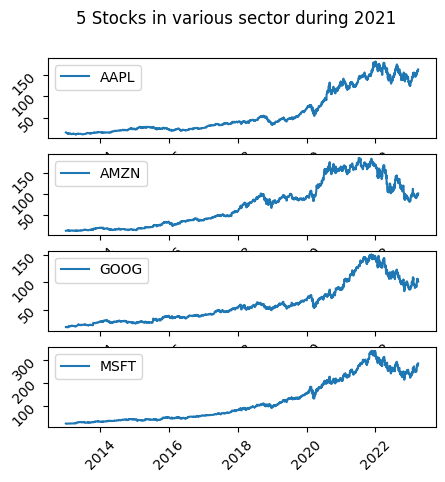

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)
fig.set_figwidth(5)
fig.suptitle('5 Stocks in various sector during 2021')

ax1.plot(AAPL['Adj Close'], label='AAPL')
ax2.plot(AMZN['Adj Close'], label='AMZN')
ax3.plot(GOOG['Adj Close'], label='GOOG')
ax4.plot(MSFT['Adj Close'], label='MSFT')
ax1.tick_params(labelrotation=45)
ax2.tick_params(labelrotation=45)
ax3.tick_params(labelrotation=45)
ax4.tick_params(labelrotation=45)
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

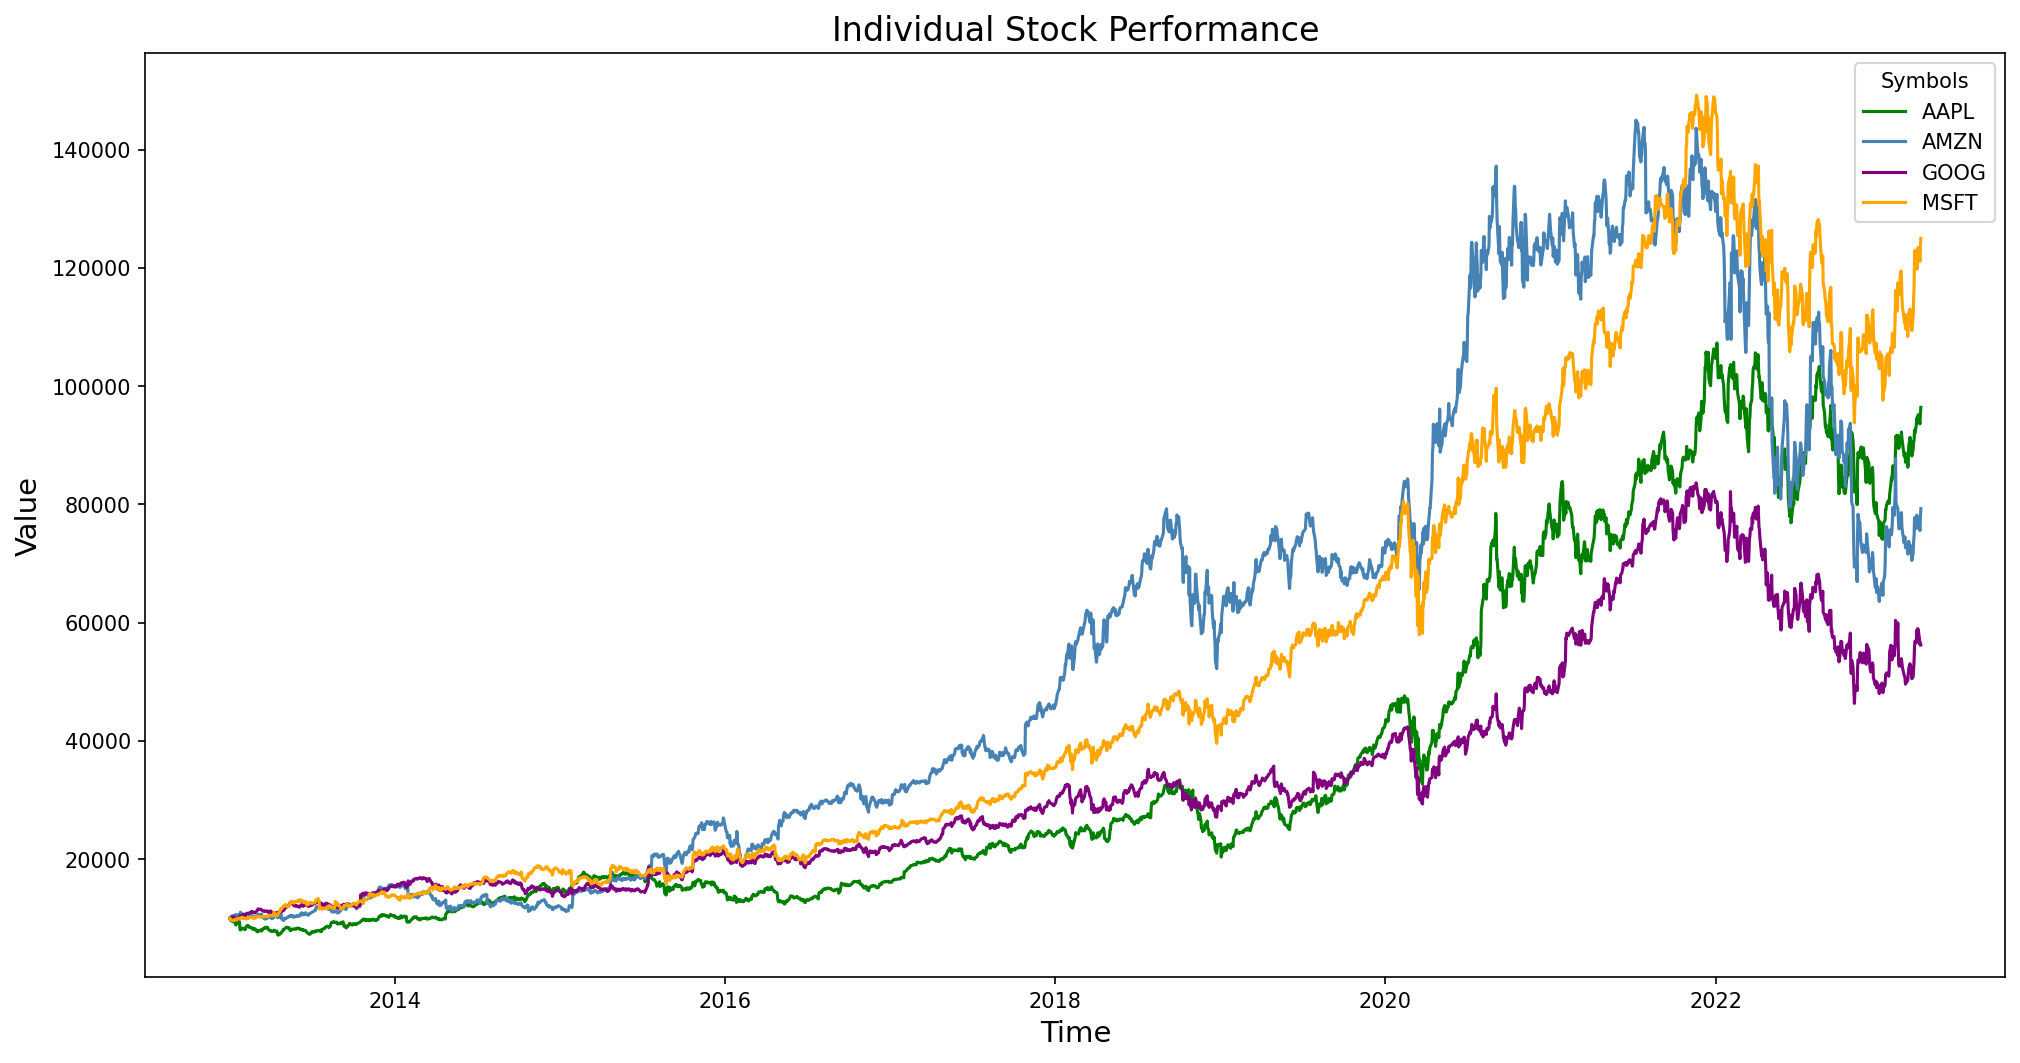

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8), dpi=150)

#plot each series
plt.plot(10000*AAPL['Adj Close']/AAPL['Adj Close'][0], label='AAPL', color='green')
plt.plot(10000*AMZN['Adj Close']/AMZN['Adj Close'][0], label='AMZN', color='steelblue')
plt.plot(10000*GOOG['Adj Close']/GOOG['Adj Close'][0], label='GOOG', color='purple')
plt.plot(10000*MSFT['Adj Close']/MSFT['Adj Close'][0], label='MSFT', color='orange')

#add legend
plt.legend(title='Symbols')

#add axes labels and a title
plt.ylabel('Value', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('Individual Stock Performance', fontsize=16)


#display plot
plt.show()

In [ ]:
def f_normalize_data(df):
    """normalizes stock data in respect to price in day 1, 
    this way price on the first day starts at 1$ for any given stock"""
    return df/df.iloc[0,:]   
    
def f_plot_data(df, title="Stock prices"):
    """Plot stock prices with a custom title and meaningful axis labels."""
    
    ax = df.plot(title=title, fontsize=12, figsize=(20, 10))
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    
    #plt.figure(figsize=(20, 10), dpi= 120, facecolor='w', edgecolor='k')
    plt.title('Relative price change')
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.style.use('bmh')
    plt.grid(True)
    plt.show()

In [ ]:
def bollinger_bands(df, n, m):
    # takes dataframe df as input
    # n = smoothing length
    # m = number of standard deviations away from moving averages
    
    #typical price
    TP = (df['High'] + df['Low'] + df['Close']) / 3
    # but we will use Adj close instead for now,  this can be customizable
    
    data = TP
    #data = df['Adj Close']  # switch or customize with logic that works better
    
    # takes one column from dataframe
    B_MA = pd.Series((data.rolling(n, min_periods=n).mean()), name='B_MA')
    sigma = data.rolling(n, min_periods=n).std() 
    
    BU = pd.Series((B_MA + m * sigma), name='BU')
    BL = pd.Series((B_MA - m * sigma), name='BL')
    
    df = df.join(B_MA)
    df = df.join(BU)
    df = df.join(BL)
    
    return df

In [ ]:
def computeRSI(data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [ ]:
n = 20   # datapoint rolling window
m = 2    # sigma width
df = bollinger_bands(stock, 20, 2)

In [ ]:
df['RSI'] = computeRSI(df['Adj Close'], 14)

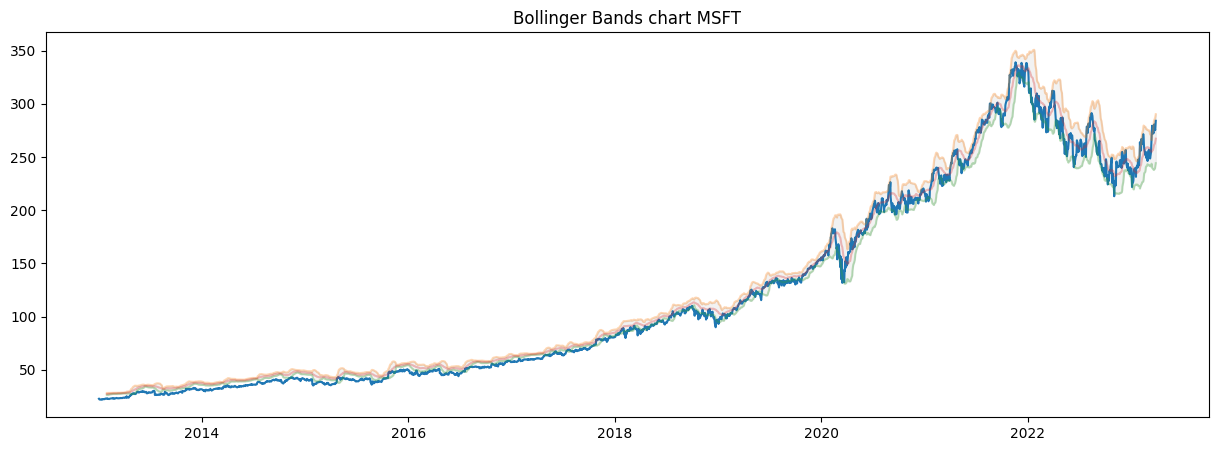

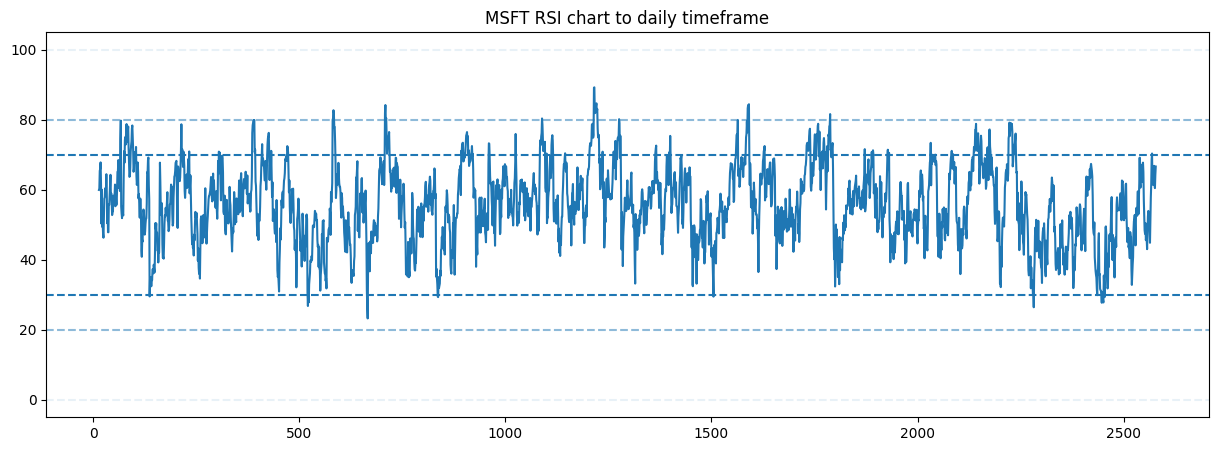

In [ ]:
# plot price
'''
plt.figure(figsize=(15,5))
plt.plot(df['Date'], df['Adj Close'])
plt.title('Price chart (Adj Close) ' + str(ticker))
plt.show()
'''
# plot correspondingRSI values and significant levels
plt.figure(figsize=(15,5))
plt.title('Bollinger Bands chart ' + str(ticker))
plt.plot(df['Date'], df['Adj Close'])
plt.plot(df['Date'], df['BU'], alpha=0.3)
plt.plot(df['Date'], df['BL'], alpha=0.3)
plt.plot(df['Date'], df['B_MA'], alpha=0.3)
plt.fill_between(df['Date'], df['BU'], df['BL'], color='grey', alpha=0.1)

# plot corresponding RSI values and significant levels
plt.figure(figsize=(15,5))
plt.title('RSI chart')
plt.title('{} RSI chart to {} timeframe'.format(ticker, 'daily'))
plt.plot(df['RSI'])

plt.axhline(0, linestyle='--', alpha=0.1)
plt.axhline(20, linestyle='--', alpha=0.5)
plt.axhline(30, linestyle='--')

plt.axhline(70, linestyle='--')
plt.axhline(80, linestyle='--', alpha=0.5)
plt.axhline(100, linestyle='--', alpha=0.1)

plt.show()

In [ ]:
#### RESAMPLING TO WEEKLY TO CLEAN NOISE

agg_dict = {'Open': 'first',
          'High': 'max',
          'Low': 'min',
          'Close': 'last',
          'Adj Close': 'last',
          'Volume': 'mean'}

# resampled dataframe
# 'W' means weekly aggregation
df.set_index('Date', inplace=True)
df_agg = df.resample('W').agg(agg_dict)
df_agg = df_agg.reset_index()

In [ ]:
# add BB columns
n = 20   # datapoint rolling window
m = 2    # sigma width
df_agg = bollinger_bands(df_agg, 20, 2)

In [ ]:
def add_signal(df):
    # adds two columns to dataframe with buy and sell signals
    buy_list = []
    sell_list = []
    
    for i in range(len(df['Close'])):
        #if df['Close'][i] > df['BU'][i]:           # sell signal     daily
        if df['High'][i] > df['BU'][i]:             # sell signal     weekly
            buy_list.append(np.nan)
            sell_list.append(df['Close'][i])
        #elif df['Close'][i] < df['BL'][i]:         # buy signal      daily
        elif df['Low'][i] < df['BL'][i]:            # buy signal      weekly
            buy_list.append(df['Close'][i])
            sell_list.append(np.nan)  
        else:
            buy_list.append(np.nan)
            sell_list.append(np.nan)
         
    buy_list = pd.Series(buy_list, name='Buy')
    sell_list = pd.Series(sell_list, name='Sell')
        
    df = df.join(buy_list)
    df = df.join(sell_list)        
     
    return df

In [ ]:
df_agg['RSI'] = computeRSI(df_agg['Adj Close'], 14)

In [ ]:
def plot_signals(df, ticker):
    # plot price
    #plt.figure(figsize=(15,5))
    #plt.plot(df['Date'], df['Adj Close'])
    #plt.title('Price chart (Adj Close) ' + str(ticker))
    #plt.show()

    # plot  values and significant levels
    plt.figure(figsize=(15,5))
    plt.title('Bollinger Bands chart ' + str(ticker))
    plt.plot(df['Date'], df['Adj Close'], label='Adj Close')

    plt.plot(df['Date'], df['High'], label='High', alpha=0.3)
    plt.plot(df['Date'], df['Low'], label='Low', alpha=0.3)

    plt.plot(df['Date'], df['BU'], label='B_Upper', alpha=0.3)
    plt.plot(df['Date'], df['BL'], label='B_Lower', alpha=0.3)
    plt.plot(df['Date'], df['B_MA'], label='B_SMA', alpha=0.3)
    plt.fill_between(df['Date'], df['BU'], df['BL'], color='grey', alpha=0.1)

    plt.scatter(df['Date'], df['Buy'], label='Buy', marker='^')
    plt.scatter(df['Date'], df['Sell'], label='Sell', marker='v')

    plt.figure(figsize=(15,5))
    plt.title('RSI chart')
    plt.title('{} RSI chart to {} timeframe'.format(ticker, 'weekly'))
    plt.plot(df['RSI'])

    plt.axhline(0, linestyle='--', alpha=0.1)
    plt.axhline(20, linestyle='--', alpha=0.5)
    plt.axhline(30, linestyle='--')

    plt.axhline(70, linestyle='--')
    plt.axhline(80, linestyle='--', alpha=0.5)
    plt.axhline(100, linestyle='--', alpha=0.1)

    plt.legend()

    plt.show()

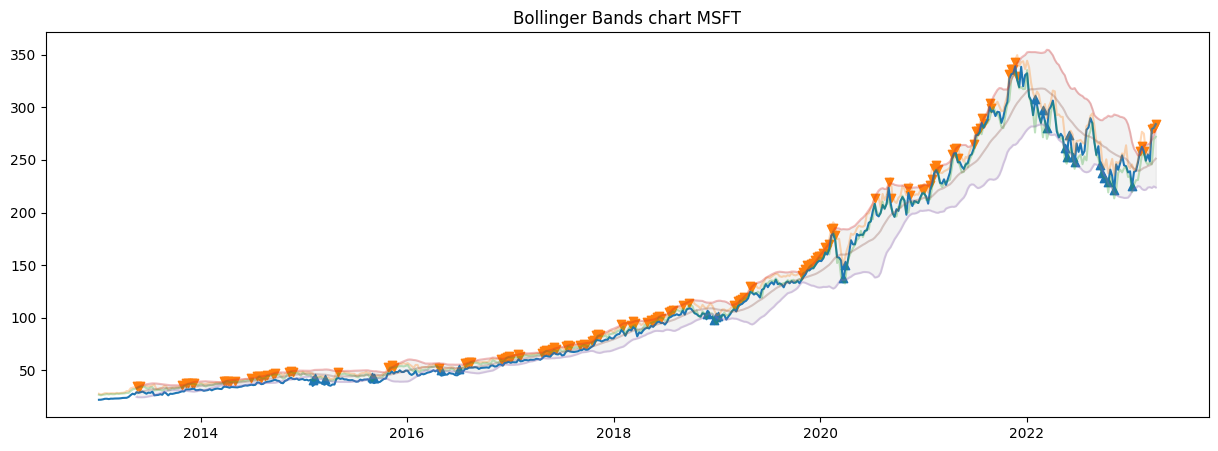

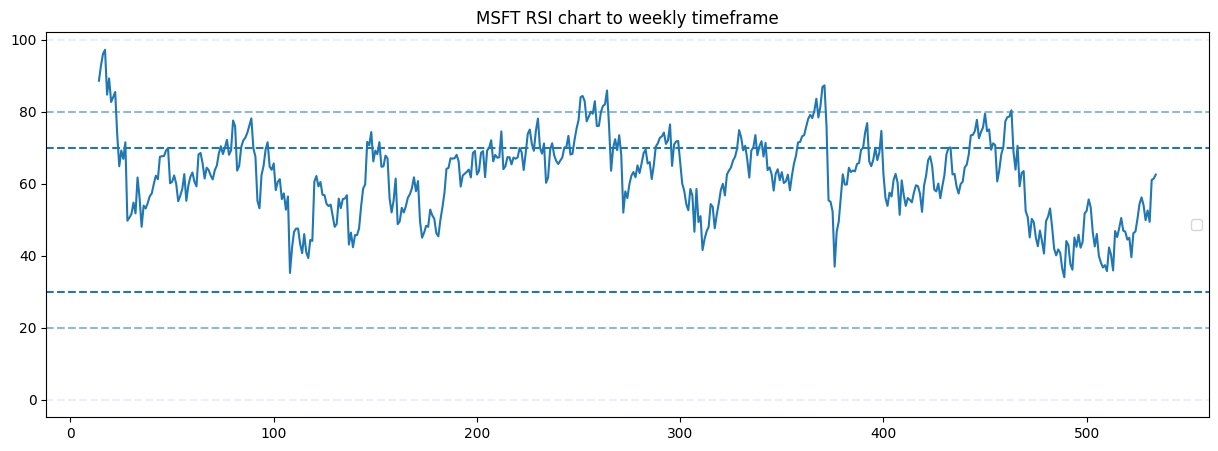

In [ ]:
df_agg = add_signal(df_agg)
plot_signals(df_agg, ticker)

In [ ]:
data = stock
data['daily_returns'] = np.log(data['Adj Close']  / data['Adj Close'].shift(1))
data['bnh_returns'] = data['daily_returns'].cumsum()
data.dropna(inplace=True)

In [ ]:
def prepare_indicators(window):
    data['moving_avg'] = data['Adj Close'].rolling(window=window).mean()
    data['moving_std'] = data['Adj Close'].rolling(window=window).std()

In [ ]:
def backtest_strategy(window, start=None):
	prepare_indicators(window)
	data['upper_band'] = 	data['moving_avg'] + 2 * data['moving_std']
	data['lower_band'] = 	data['moving_avg'] - 2 * data['moving_std']

	if start is None:
		start = window

	# BUY condition
	data['signal'] = 	np.where((data['Adj Close'] < data['lower_band']) &
			 (data['Adj Close'].shift(1) >= data['lower_band']), 1, 0)

	# SELL condition
	data['signal'] = 	np.where((data['Adj Close'] > data['upper_band']) &
			 (data['Adj Close'].shift(1) <= data['upper_band']), -1,
			  data['signal'])

	data['position'] = data['signal'].replace(to_replace=0, method='ffill')
	data['position'] = data['position'].shift()

	data['strategy_returns'] = data['position'] * data['daily_returns']

	performance = data[['daily_returns', 'strategy_returns']].iloc[start:].sum()

	data['strategy_returns'] = data['strategy_returns'].cumsum()
	return performance

In [ ]:
def optimize_bollinger_band_parameters(windows):
	start = max(windows)
	results = pd.DataFrame()
	for window in windows:
		perf = backtest_strategy(window=window, start=start)
		result = pd.DataFrame({'Window': window,
									'bnh returns': perf['daily_returns'],
									'strategy returns': perf['strategy_returns']}, 
									 index=[0, ])
		results = results.append(result, ignore_index=True)
	results.sort_values(by='strategy returns', inplace=True, ascending=False)
	results = results.reset_index()
	return  results.drop("index", axis=1)

In [ ]:
def plot_data( attribute_list):
    data[attribute_list].plot()
    plt.show()

In [ ]:
def plot_optimized_bollinger_strategy_returns(results):
  if (len(results)) > 0:
    window = results.loc[0, 'Window']
    print("Window:", window)
    backtest_strategy(window=window)
    data[['bnh_returns', 'strategy_returns']].plot()
    plt.show()
    

In [ ]:
results = optimize_bollinger_band_parameters(range(1, 50, 1))

<ipython-input-30-8f9f90de5427>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result, ignore_index=True)
<ipython-input-30-8f9f90de5427>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result, ignore_index=True)
<ipython-input-30-8f9f90de5427>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result, ignore_index=True)
<ipython-input-30-8f9f90de5427>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result, ignore_index=True)
<ipython-input-30-8f9f90de5427>:10: FutureWarning: The frame.append method is deprecated and will be removed

Window: 12


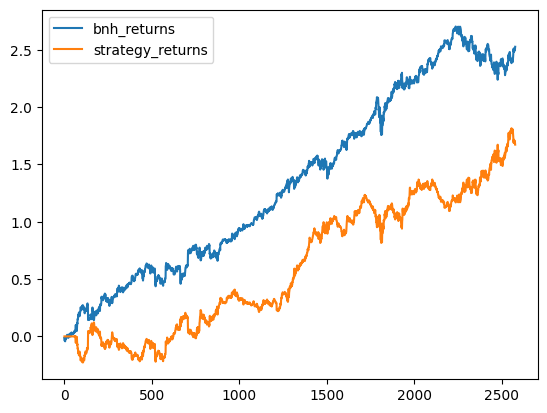

In [ ]:
plot_optimized_bollinger_strategy_returns(results)

In [ ]:
import pyfolio as pf

/usr/local/lib/python3.10/dist-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [ ]:
 # function to create a simple tear sheet using pyfolio
def create_simple_tear_sheet(data):
    pf.display(\
    pf.create_simple_tear_sheet(data['strategy_returns'].diff()))

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2013-01-03
End date,2023-03-30
Total months,122
,Backtest
Annual return,13.52%
Cumulative returns,265.924%
Annual volatility,27.09%
Sharpe ratio,0.60
Calmar ratio,0.36
Stability,0.90
Max drawdown,-37.27%


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


None

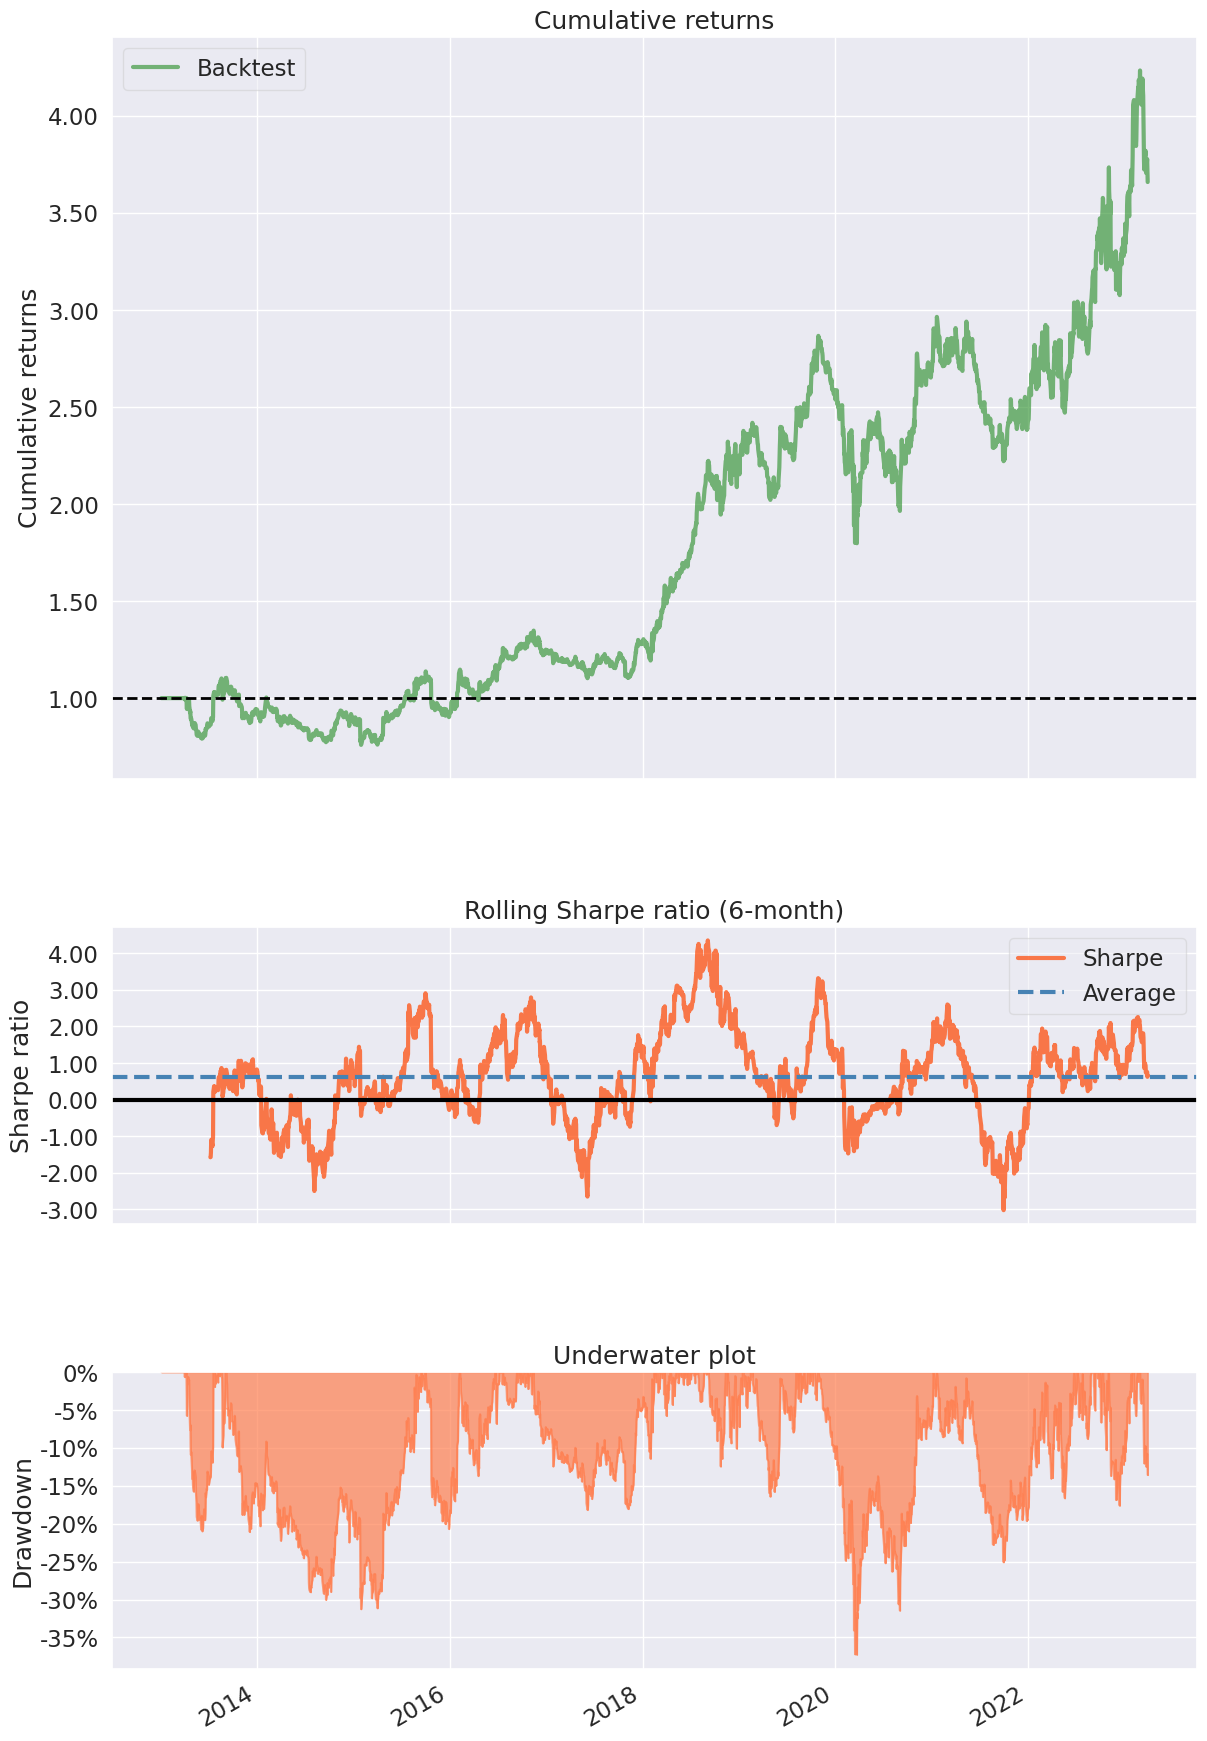

In [ ]:
if 'Date' in data.columns:
  data.set_index('Date', inplace=True)
create_simple_tear_sheet(data)

In [ ]:
import backtrader as bt

In [ ]:
class BollBander(bt.Strategy):
''' This class extends backtrader strategy class to use built in functions such as indicators  '''
# Set a bollinger band indicator, buy when the price exceeds the lower band, sell when price exceeds higher band.

# Set the parameters for the bollinger band. I chose a 21 day period as that mimics the number of days in a trading month, a smaller standard deviation on the band
# gives more entry & exit opportunities

    params = dict(
        bperiod=21
        ,dev=1.25)
    
    def __init__(self):
        
        #Define Bolligner band
        
        self.boll = bt.ind.BollingerBands(period=self.p.bperiod, devfactor=self.p.dev, plot=True, plotname='Bollinger Band', subplot=False)
        
        #Define cross-over points
        
        self.buysig = bt.indicators.CrossOver(self.data0, self.boll.lines.bot, plotname='buy signal', plot=True)
        self.sellsig = bt.indicators.CrossOver(self.data0, self.boll.lines.top,plotname='sell signal', plot=True)

    def next(self):
        
        if not self.position:  # not in the market
            if self.buysig > 0:  # if fast crosses slow to the upside
                self.order_target_size(target=3000)   # enter long
                
        elif self.sellsig > 0:  # in the market & cross to the downside
            self.order_target_size(target=0)   # close long position 
        

Cerebro class is the cornerstone of backtrader bcause it serves as a central point for:

Gathering all inputs (Data Feeds), actors (Stratgegies), spectators (Observers), critics (Analyzers) and documenters (Writers) ensuring the show still goes on at any moment.

Execute the backtesting/or live data feeding/trading

Returning the results

Giving access to the plotting facilities

In [ ]:
import os
from datetime import datetime

param_opt = False
perf_eval = True
benchmark = 'AAPL'

cerebro = bt.Cerebro()

datapath = os.path.join('/content/drive/My Drive/SwingTrader//data/', 'AAPL.csv')

# Create a Data Feed
data = bt.feeds.YahooFinanceCSVData(
    dataname=datapath,
    fromdate=datetime(2014, 1, 3),
    todate=datetime(2022, 12, 31),
    reverse=False)
    

#data = bt.feeds.YahooFinanceData(dataname='MSFT', fromdate=datetime(2011, 1, 1),todate=datetime(2012, 12, 31))

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(100000.0)

# Add a FixedSize sizer according to the stake
# cerebro.addsizer(bt.sizers.FixedSize, stake=10)
# PercentSizer will flat position first; overwrite if not desired.
cerebro.addsizer(bt.sizers.PercentSizerInt, percents=95)

# Set the commission - 0.1% ... divide by 100 to remove the %
cerebro.broker.setcommission(commission=0.001)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Add a strategy
if param_opt:
    # Optimization
    cerebro.optstrategy(BollBander)
    perf_eval = False
else:
    cerebro.addstrategy(BollBander)

# Add Analyzer
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='SharpeRatio')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DrawDown')
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

# Run over everything
results = cerebro.run()

# Print out the final result
strat = results[0]
print('Final Portfolio Value: %.2f, Sharpe Ratio: %.2f, DrawDown: %.2f, MoneyDown %.2f' %
      (cerebro.broker.getvalue(),
        strat.analyzers.SharpeRatio.get_analysis()['sharperatio'],
        strat.analyzers.DrawDown.get_analysis()['drawdown'],
        strat.analyzers.DrawDown.get_analysis()['moneydown']))

if perf_eval:
    import matplotlib.pyplot as plt
    cerebro.plot(style='candlestick')
    plt.show()

    pyfoliozer = strat.analyzers.getbyname('pyfolio')
    returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
    print('-------------- RETURNS ----------------')
    print(returns)
    print('-------------- POSITIONS ----------------')
    print(positions)
    print('-------------- TRANSACTIONS ----------------')
    print(transactions)
    print('-------------- GROSS LEVERAGE ----------------')
    print(gross_lev)

    import empyrical as ep
    import pyfolio as pf

    bm_ret = None
    if benchmark:
        datapath = os.path.join('/content/drive/My Drive/SwingTrader//data/', f'{benchmark}.csv')
        bm = pd.read_csv(datapath, index_col=0)
        bm_ret = bm['Adj Close'].pct_change().dropna()
        bm_ret.index = pd.to_datetime(bm_ret.index)
        # remove tzinfo
        returns.index = returns.index.tz_localize(None)
        bm_ret = bm_ret[returns.index]
        bm_ret.name = 'benchmark'

    perf_stats_strat = pf.timeseries.perf_stats(returns)
    perf_stats_all = perf_stats_strat
    if benchmark:
        perf_stats_bm = pf.timeseries.perf_stats(bm_ret)
        perf_stats_all = pd.concat([perf_stats_strat, perf_stats_bm], axis=1)
        perf_stats_all.columns = ['Strategy', 'Benchmark']

    drawdown_table = pf.timeseries.gen_drawdown_table(returns, 5)
    monthly_ret_table = ep.aggregate_returns(returns, 'monthly')
    monthly_ret_table = monthly_ret_table.unstack().round(3)
    ann_ret_df = pd.DataFrame(ep.aggregate_returns(returns, 'yearly'))
    ann_ret_df = ann_ret_df.unstack().round(3)
    print('-------------- PERFORMANCE ----------------')
    print(perf_stats_all)
    print('-------------- DRAWDOWN ----------------')
    print(drawdown_table)
    print('-------------- MONTHLY RETURN ----------------')
    print(monthly_ret_table)
    print('-------------- ANNUAL RETURN ----------------')
    print(ann_ret_df)

    pf.create_full_tear_sheet(
        returns,
        benchmark_rets=bm_ret if benchmark else None,
        positions=positions,
        transactions=transactions,
        #live_start_date='2005-05-01',
        round_trips=False)
    plt.show()

Starting Portfolio Value: 100000.00
Final Portfolio Value: 121297.72, Sharpe Ratio: 0.22, DrawDown: 25.02, MoneyDown 40470.06


<IPython.core.display.Javascript object>

-------------- RETURNS ----------------
index
2014-01-03 00:00:00+00:00    0.0
2014-01-06 00:00:00+00:00    0.0
2014-01-07 00:00:00+00:00    0.0
2014-01-08 00:00:00+00:00    0.0
2014-01-09 00:00:00+00:00    0.0
                            ... 
2022-12-23 00:00:00+00:00    0.0
2022-12-27 00:00:00+00:00    0.0
2022-12-28 00:00:00+00:00    0.0
2022-12-29 00:00:00+00:00    0.0
2022-12-30 00:00:00+00:00    0.0
Name: return, Length: 2265, dtype: float64
-------------- POSITIONS ----------------
                           AAPL       cash
Datetime                                  
2014-01-03 00:00:00+00:00   0.0  100000.00
2014-01-06 00:00:00+00:00   0.0  100000.00
2014-01-07 00:00:00+00:00   0.0  100000.00
2014-01-08 00:00:00+00:00   0.0  100000.00
2014-01-09 00:00:00+00:00   0.0  100000.00
...                         ...        ...
2022-12-23 00:00:00+00:00   0.0  121297.72
2022-12-27 00:00:00+00:00   0.0  121297.72
2022-12-28 00:00:00+00:00   0.0  121297.72
2022-12-29 00:00:00+00:00   0.0  

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


-------------- PERFORMANCE ----------------
                      Strategy  Benchmark
Annual return         0.021714   0.250556
Cumulative returns    0.212977   6.460581
Annual volatility     0.105815   0.291372
Sharpe ratio          0.256243   0.913416
Calmar ratio          0.060951   0.650526
Stability             0.148983   0.926091
Max drawdown         -0.356251  -0.385159
Omega ratio           1.112580   1.180615
Sortino ratio         0.353086   1.335897
Skew                 -1.214009  -0.027113
Kurtosis             46.776285   5.417719
Tail ratio            1.304217   1.038366
Daily value at risk  -0.013224  -0.035653
-------------- DRAWDOWN ----------------
  Net drawdown in %  Peak date Valley date Recovery date Duration
0         35.625141 2018-10-23  2019-01-03           NaT      NaN
1         14.430584 2015-11-20  2016-01-27    2016-11-21      262
2          8.692937 2015-08-10  2015-08-24    2015-10-09       45
3          4.863423 2014-12-26  2015-01-16    2015-01-28       

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2014-01-03
End date,2022-12-30
Total months,107
,Backtest
Annual return,2.171%
Cumulative returns,21.298%
Annual volatility,10.581%
Sharpe ratio,0.26
Calmar ratio,0.06
Stability,0.15
Max drawdown,-35.625%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,35.63,2018-10-23,2019-01-03,NaT,NaN
1,14.43,2015-11-20,2016-01-27,2016-11-21,262
2,8.69,2015-08-10,2015-08-24,2015-10-09,45
3,4.86,2014-12-26,2015-01-16,2015-01-28,24
4,4.71,2015-06-24,2015-07-09,2015-07-16,17


<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this w

Stress Events,mean,min,max
Apr14,0.14%,-0.69%,3.96%
Oct14,0.06%,-0.97%,1.68%
Fall2015,0.00%,-4.14%,3.79%
New Normal,0.01%,-9.84%,6.95%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Top 10 long positions of all time,max
AAPL,99.16%


Top 10 short positions of all time,max


Top 10 positions of all time,max
AAPL,99.16%


<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:1553: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(turnover, ax=ax, **kwargs)
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:1633: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  txn_time = txn_time.groupby(level=0).sum().reindex(index=range(570, 961))


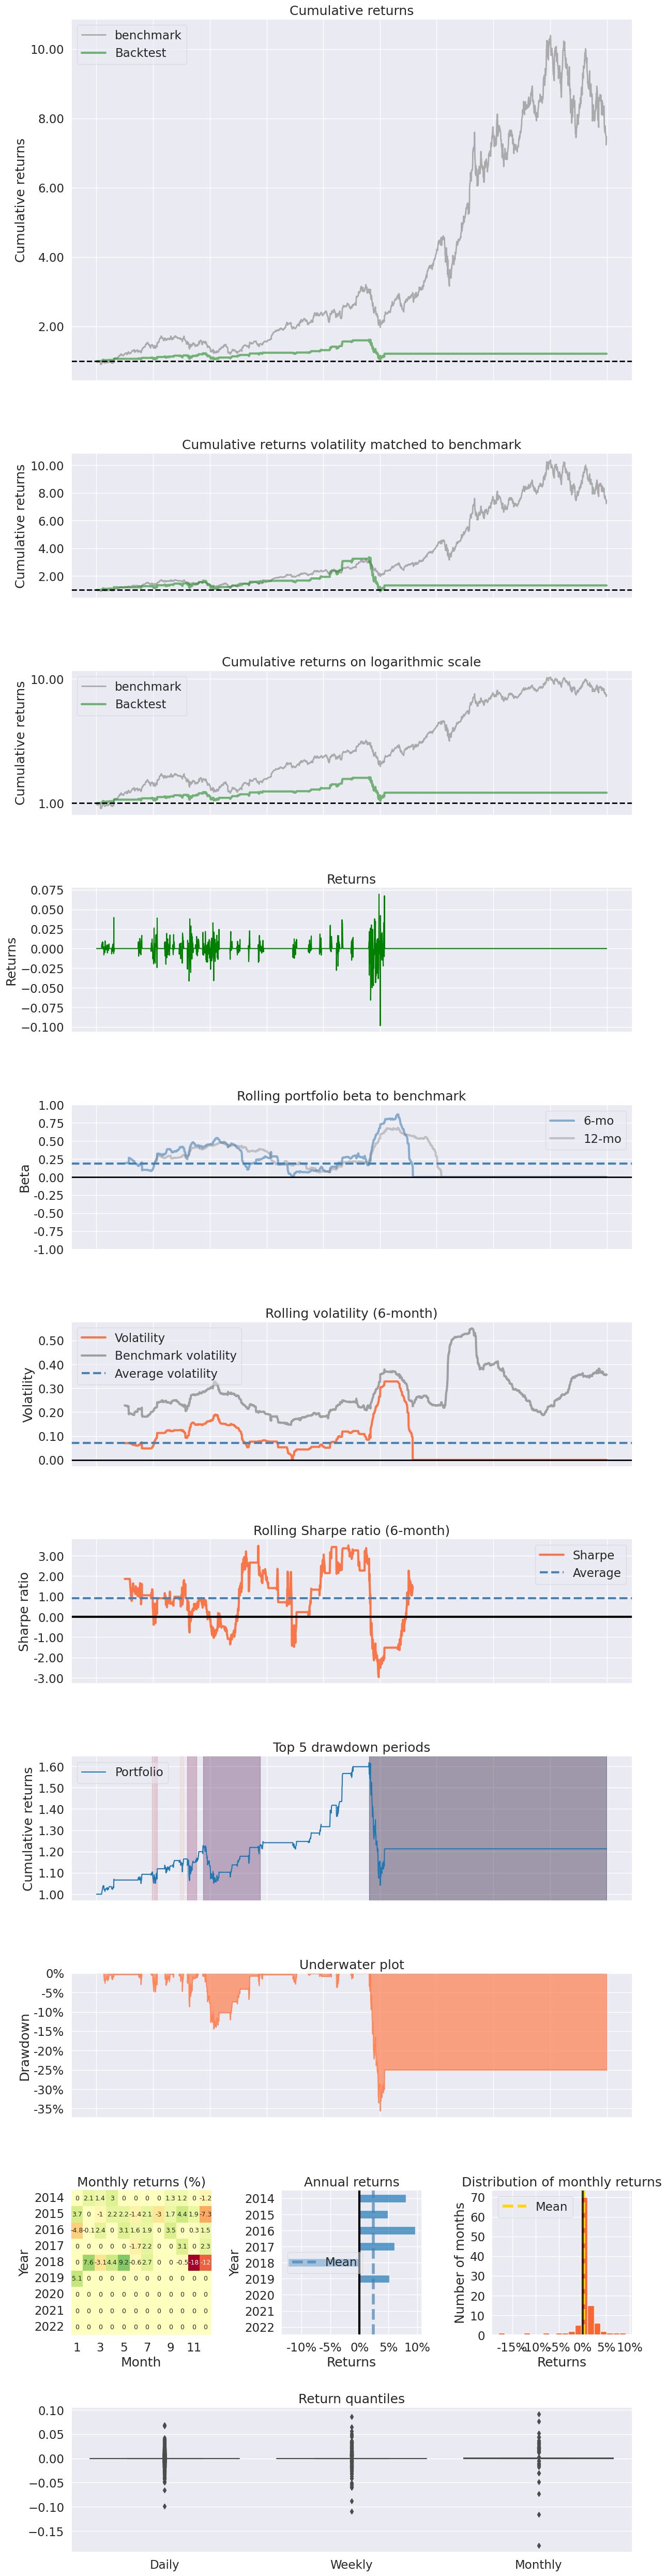

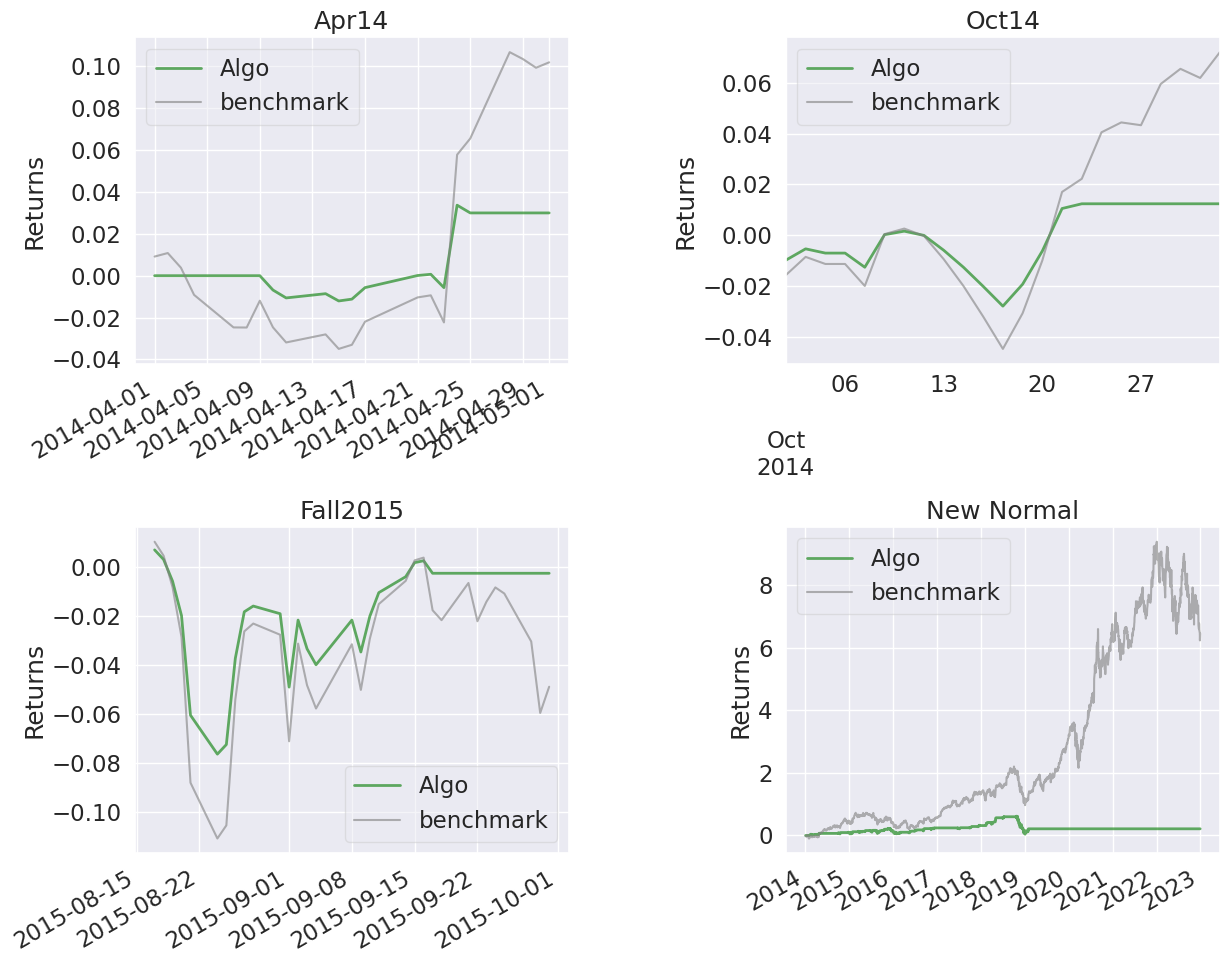

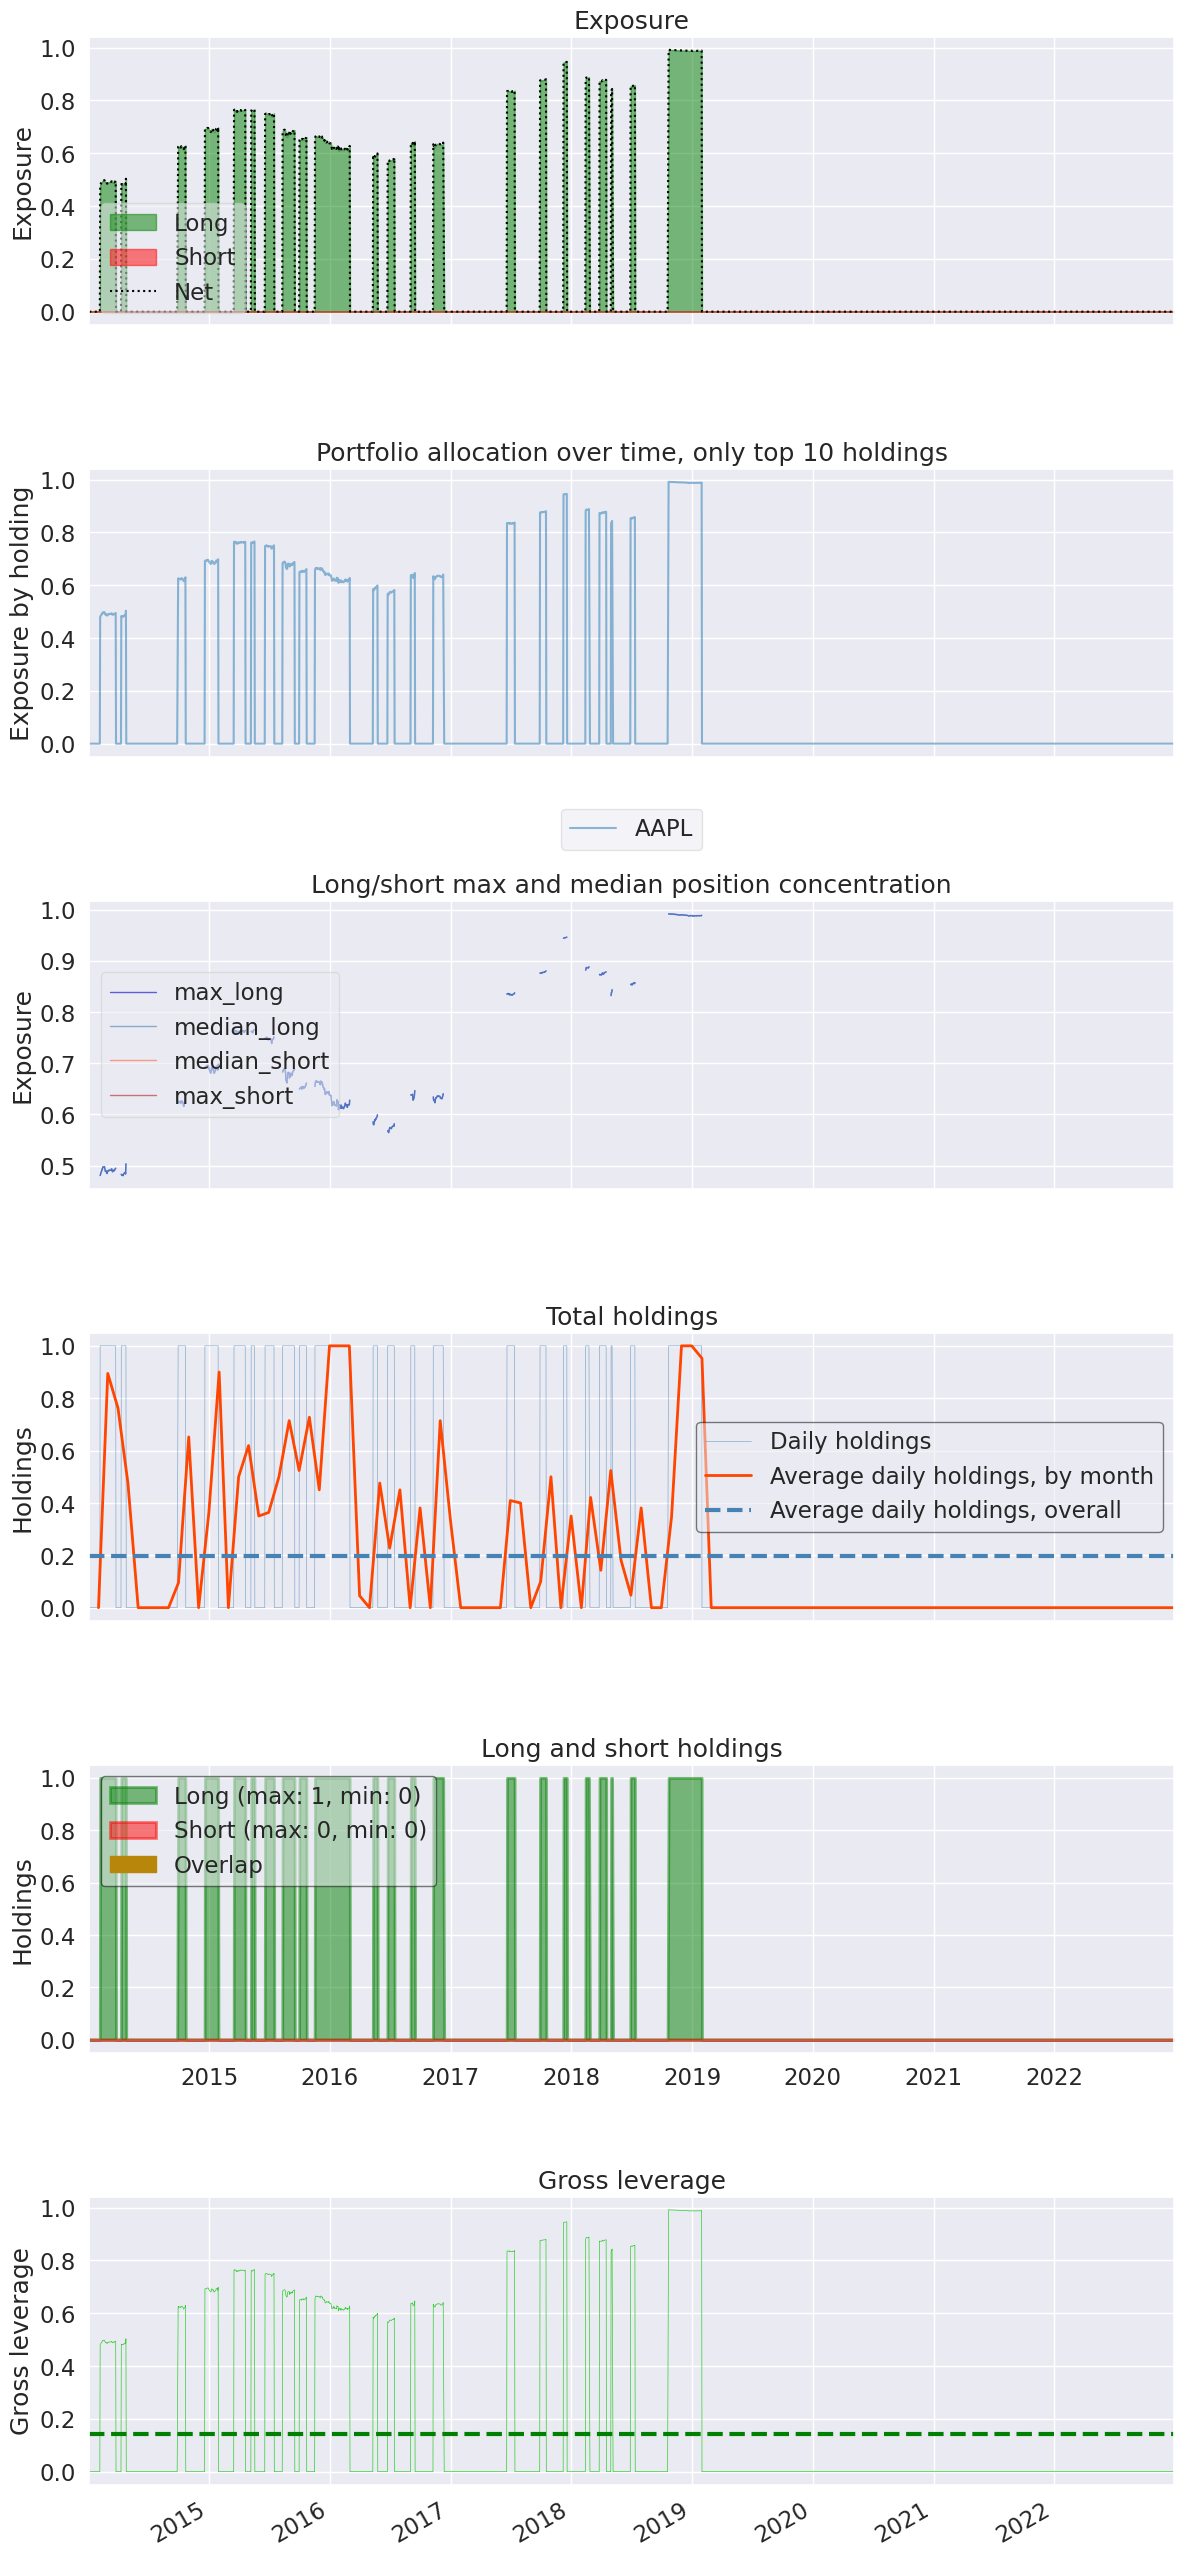

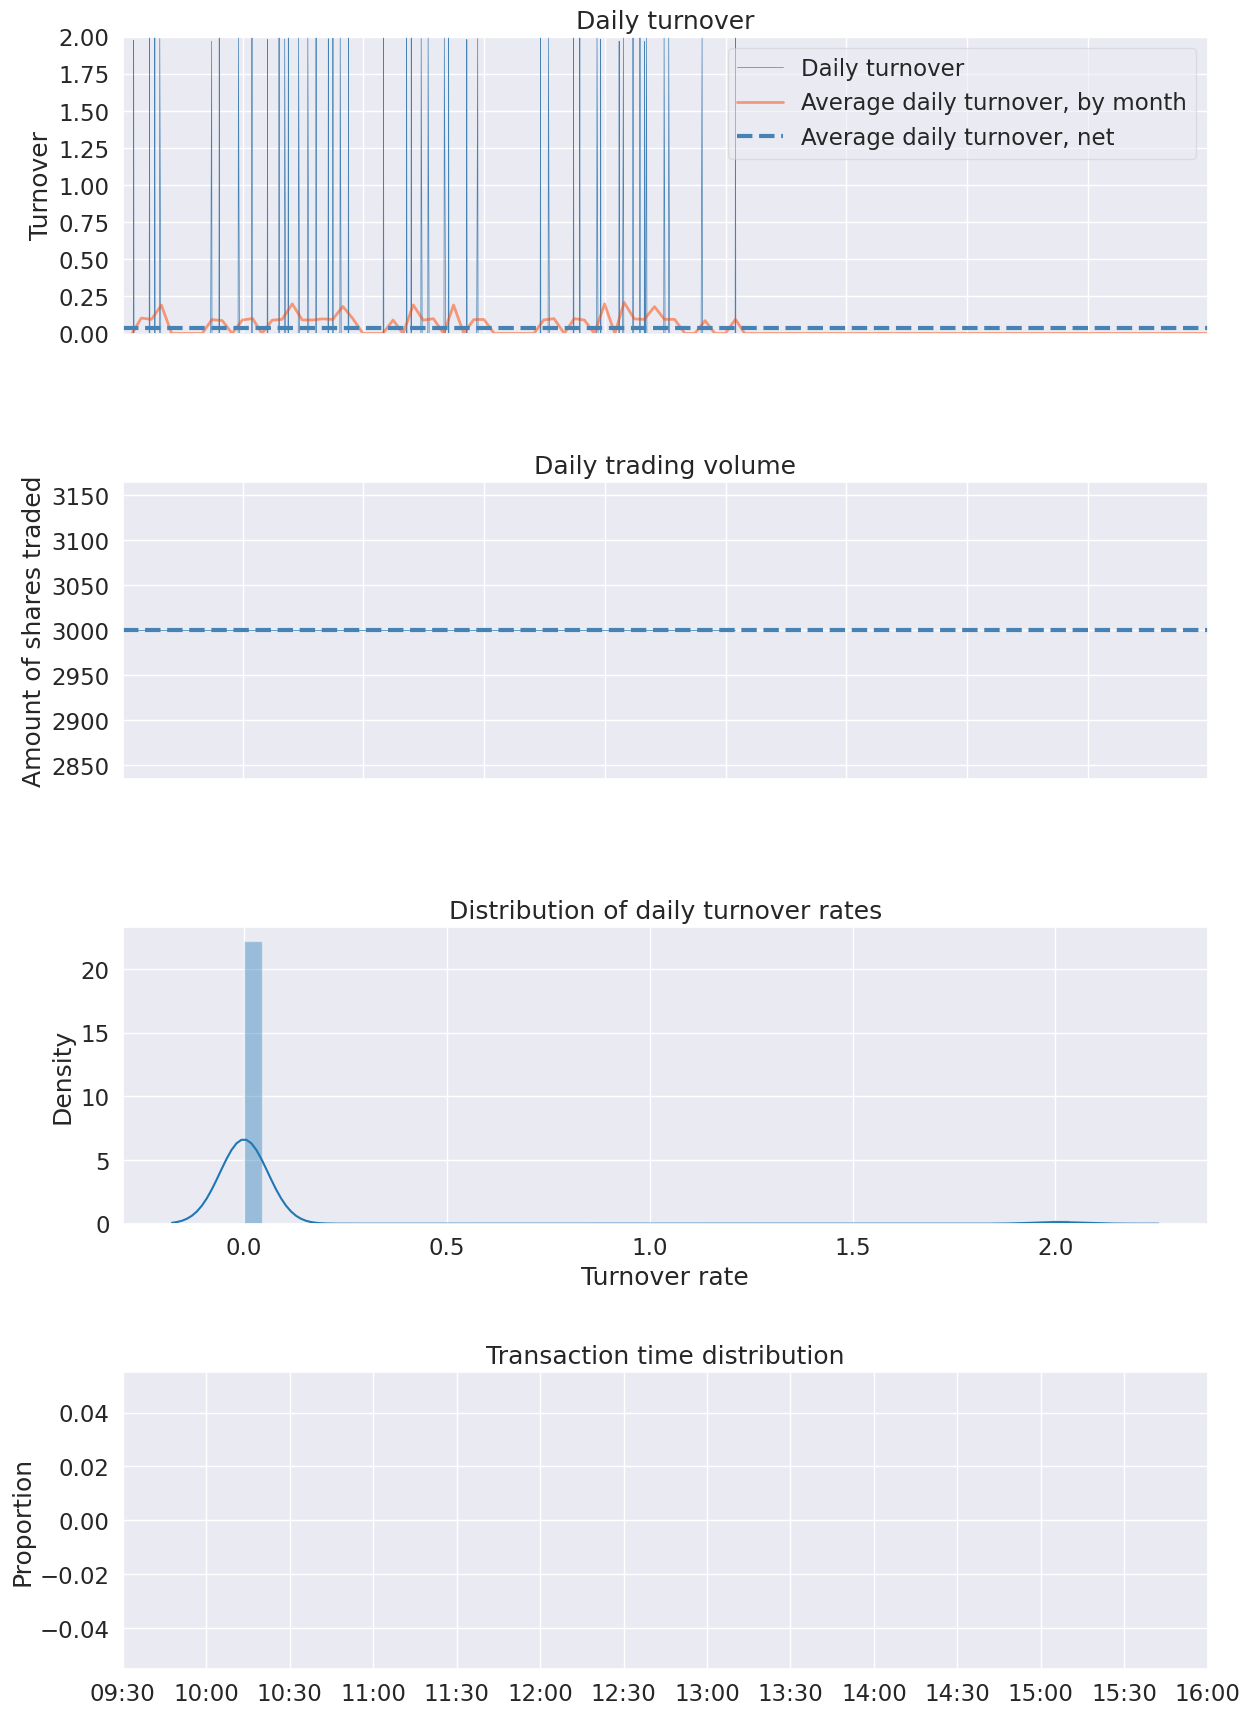

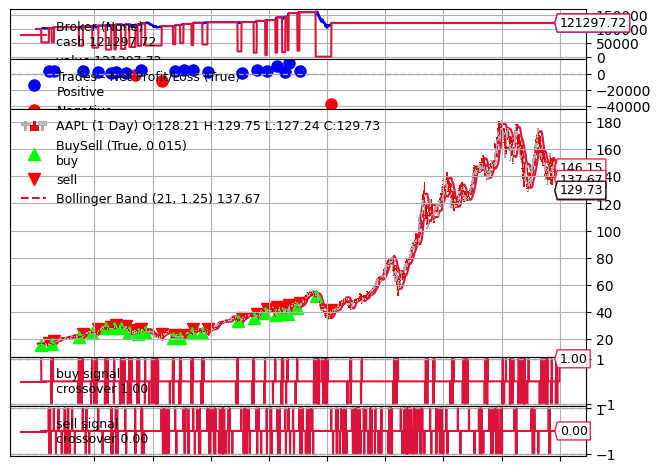

[[<Figure size 640x480 with 5 Axes>]]

In [ ]:
%matplotlib inline
cerebro.plot(iplot=False, volume=False, width=20)

### References

https://www.backtrader.com/docu/
